In [1]:
!pip install pycocotools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 458.7/458.7 kB 10.7 MB/s eta 0:00:00 0:00:01


In [2]:
import os

paths=[]
labels=[]
feature_id = []
count = 0
for dirname, _, filenames in os.walk('imagenet/images/train'):
    for filename in filenames:
        if filename[-4:]=='JPEG':
            paths+=[(os.path.join(dirname, filename))]
            feature_id+=[(os.path.join(dirname, filename))[len("imagenet/images/train")+1:]]
            label=dirname.split('/')[-1]
            labels+=[label]
            if os.path.isfile("imagenet/bboxes_annotations/"+(os.path.join(dirname, filename))[len("imagenet/images/train")+1:][:-4]+"xml") == False:
                paths.pop()
                feature_id.pop()
                labels.pop()
                count += 1
                # print((os.path.join(dirname, filename))[len("images/train")+1:][:-4]+"xml")
            
print(len(paths))
# print(count)
            
tpaths=[]
tlabels=[]
for dirname, _, filenames in os.walk('imagenet/images/val'):
    for filename in filenames:
        if filename[-4:]=='JPEG':
            tpaths+=[(os.path.join(dirname, filename))]
            label=dirname.split('/')[-1]
            tlabels+=[label]

all_labels=os.listdir('imagenet/images/train')

# print(len(all_labels))

12982


In [3]:
from torchvision.transforms import v2 as T

# /Users/ronaksingh/Documents/Github/NGHackathon24/imagenet/bboxes_annotations/n04107743/n00141669_73.xml

def get_transform(train):
    transforms = []
    if train:
        # transforms.append(T.RandomResizedCrop(size=(224, 224), antialias=True))
        # transforms.append(T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)))
        # transforms.append(T.RandomPhotometricDistort(0.5))
        transforms.append(T.RandomHorizontalFlip(1))
    transforms.append(T.ToDtype(torch.float, scale=True))
    # transforms.append(T.TenCrop(32)) # this is a tuple of PIL Images
    # transforms.append(T.Lambda(lambda crops: torch.stack([T.PILToTensor()(crop) for crop in crops]))),
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [4]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
import xml.etree.ElementTree as ET
from torchvision.datasets import ImageNet
from torch.utils.data import DataLoader

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks


# labelsMaster = ["bg", "Musical keyboard", "Piano", "Wheel", "Car", "Mirror", "Clothing", "Chair", "Ladder", "Music stand", "Table", "Chair", "Building (group)", "Drink (group)", "Shelf", "Book", "Book (group)", "Camera", "Drink", "Desk", "Human arm", "Human hair", "Human leg", "Human hand", "Watch", "Screen", "Woman"]


def read_pascal_voc_annotation(xml_file):
    # tree = ET.parse(xml_file, parser = ET.XMLParser(encoding = 'iso-8859-5'))
    # print(xml_file)
    tree = ET.parse(xml_file)

    root = tree.getroot()

    annotations = []
    for obj in root.findall('object'):
        bbox = obj.find('bndbox')
        xmin = float(bbox.find('xmin').text)
        ymin = float(bbox.find('ymin').text)
        xmax = float(bbox.find('xmax').text)
        ymax = float(bbox.find('ymax').text)
        label = obj.find('name').text

        annotations.append({
            'bbox': [xmin, ymin, xmax, ymax],
            'label': label
        })

    return annotations

# print(read_pascal_voc_annotation('../imagenet/bboxes_annotations/n01440764/n01440764_1775.xml'))

# imagenet_train = ImageNet(root="../imagenet/images/train/", split='train', transform=get_transform(train=True))


class ImageNetDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        # self.imgs = list(sorted(os.listdir(os.path.join(root, "JPGImages"))))
        # self.annotations = list(sorted(os.listdir(os.path.join(root, "Annotations"))))
        self.imgs = paths
        self.annotations = feature_id
        # self.annotations = ann_paths

    def __getitem__(self, idx):
        # load images and masks
        # img_path = os.path.join(self.root, "JPGImages", self.imgs[idx])
        # annotation_path = os.path.join(self.root, "Annotations", self.annotations[idx])
        img_path = self.imgs[idx]
        annotation_path = os.path.join(self.root, "imagenet/bboxes_annotations", (self.annotations[idx][:-4]+"xml"))
        img = read_image(img_path)

        # print(img_path)
        
        annotation_out = read_pascal_voc_annotation(annotation_path)

        # instances are encoded as different colors
        # obj_ids = torch.unique(img)
        # first id is the background, so remove it
        # obj_ids = obj_ids[1:]
        num_objs = len(annotation_out)

        # print(num_objs)

        # split the color-encoded mask into a set
        # of binary masks
        # masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        # boxes = masks_to_boxes(masks)
        # boxesList = [a["bbox"] for a in annotation_out]
        boxesList = []
        # boxes = torch.tensor(np.array(boxesList), dtype=float)

        # there is only one class
        # labels = torch.ones((num_objs,), dtype=torch.int64)

        # labelList = [labelsMaster.index(a["label"]) for a in annotation_out]

        # labelList = [labels.index(a["label"]) for a in annotation_out]
        labelList = []

        for a in annotation_out:
            if a["label"] in all_labels:
                labelList += [all_labels.index(a["label"])+1]
                boxesList += [a["bbox"]]

        boxes = torch.tensor(np.array(boxesList), dtype=float)
        
        tensorLabel = torch.tensor(np.array(labelList), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["labels"] = tensorLabel
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        # print(target["boxes"].long())

        # image = (255.0 * (img - img.min()) / (img.max() - img.min())).to(torch.uint8)
        # image = image[:3, ...]
        # pred_labels = [f"{label}" for label in target["labels"]]
        # # pred_labels = [f"person"]
        # pred_boxes = target["boxes"].long()
        # output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")
        # # print(output_image)

        # # plt.figure(figsize=(12, 12))
        # plt.imshow(output_image.permute(1, 2, 0))

        # print(target["boxes"])

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [5]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.roi_heads.score_thresh = 0

    return model

model = get_model_instance_segmentation(len(all_labels)+1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 244MB/s] 


In [6]:
import math
import utils
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from engine import train_one_epoch, evaluate

assert torch.cuda.is_available(), "GPU not available"

model = get_model_instance_segmentation(1001)
model.load_state_dict(torch.load("imagenet_finetune_fix_26.pth", weights_only=True))
# model.eval()
model.roi_heads.score_thresh = 0.5

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

dataset = ImageNetDataset('imagenet/', get_transform(train=True))
dataset_test = ImageNetDataset('imagenet/', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset_test = torch.utils.data.Subset(dataset_test, indices[-500:])
dataset = torch.utils.data.Subset(dataset, indices[:-500])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    collate_fn=utils.collate_fn
)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.001,
    momentum=0.9,
    weight_decay=0.0005
)

lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

model.to(device)
num_epochs = 50

for epoch in range(27,num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # torch.save(model.state_dict(), f'imagenet_finetune_weights_f{epoch}.pth')
#     # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)
    torch.save(model.state_dict(), f'imagenet_finetune_fix_{epoch}.pth')

# torch.save(model.state_dict(), 'test_finetune_weights.pth')
print("That's it!")

2024-10-30 22:12:34.083139: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-30 22:12:34.083274: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-30 22:12:34.167608: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-30 22:12:34.341039: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-30 22:12:35.959701: W tensorflow/compiler/tf2

Epoch: [27]  [   0/3121]  eta: 5:06:37  lr: 0.001000  loss: 0.1502 (0.1502)  loss_classifier: 0.0694 (0.0694)  loss_box_reg: 0.0437 (0.0437)  loss_objectness: 0.0032 (0.0032)  loss_rpn_box_reg: 0.0340 (0.0340)  time: 5.8947  data: 0.1233  max mem: 5189
Epoch: [27]  [  10/3121]  eta: 0:55:04  lr: 0.001000  loss: 0.1663 (0.1804)  loss_classifier: 0.0825 (0.1012)  loss_box_reg: 0.0654 (0.0640)  loss_objectness: 0.0013 (0.0014)  loss_rpn_box_reg: 0.0102 (0.0137)  time: 1.0620  data: 0.0998  max mem: 6848
Epoch: [27]  [  20/3121]  eta: 0:42:31  lr: 0.001000  loss: 0.1876 (2.0297)  loss_classifier: 0.1090 (0.1042)  loss_box_reg: 0.0640 (0.0633)  loss_objectness: 0.0011 (0.0334)  loss_rpn_box_reg: 0.0102 (1.8288)  time: 0.5690  data: 0.0852  max mem: 7185
Epoch: [27]  [  30/3121]  eta: 0:38:52  lr: 0.001000  loss: 0.2140 (1.4674)  loss_classifier: 0.1208 (0.1126)  loss_box_reg: 0.0675 (0.0719)  loss_objectness: 0.0012 (0.0401)  loss_rpn_box_reg: 0.0103 (1.2428)  time: 0.5855  data: 0.0866  ma

KeyboardInterrupt: 

tensor([0.0192, 0.0095, 0.0088, 0.0088, 0.0084, 0.0083, 0.0081, 0.0080, 0.0073,
        0.0072, 0.0064, 0.0061, 0.0056, 0.0056, 0.0051, 0.0051, 0.0049, 0.0049,
        0.0049, 0.0049, 0.0048, 0.0047, 0.0043, 0.0043, 0.0043, 0.0042, 0.0042,
        0.0042, 0.0041, 0.0041, 0.0040, 0.0040, 0.0039, 0.0039, 0.0039, 0.0039,
        0.0039, 0.0039, 0.0039, 0.0038, 0.0038, 0.0037, 0.0037, 0.0037, 0.0037,
        0.0037, 0.0036, 0.0035, 0.0035, 0.0035, 0.0034, 0.0034, 0.0034, 0.0033,
        0.0033, 0.0033, 0.0033, 0.0033, 0.0032, 0.0032, 0.0031, 0.0031, 0.0031,
        0.0031, 0.0031, 0.0031, 0.0031, 0.0030, 0.0030, 0.0030, 0.0030, 0.0029,
        0.0029, 0.0029, 0.0029, 0.0029, 0.0029, 0.0029, 0.0029, 0.0029, 0.0029,
        0.0029, 0.0029, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028,
        0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0027,
        0.0027], device='cuda:0')
['n03920288: 0.019']


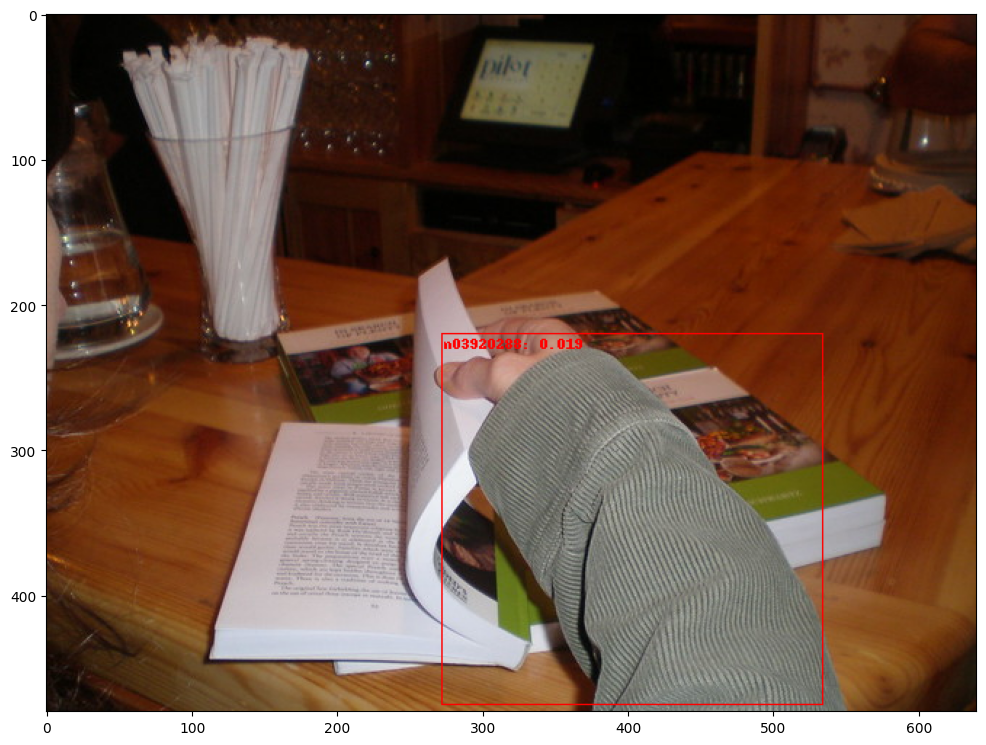

In [11]:
import torch
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# image = read_image("PennFudanPed/PNGImages/PennPed00096.png")
image = read_image("quick_start_pytorch_images/Image2.jpg")
eval_transform = get_transform(train=False)

# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# model.eval()
# model.to(device)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


model = get_model_instance_segmentation(1001)
model.load_state_dict(torch.load("imagenet_finetune_fix_2.pth", weights_only=True))
model.eval()

model.to(device)

coco_names = ["person" , "bicycle" , "car" , "motorcycle" , "airplane" , "bus" , "train" , "truck" , "boat" , "traffic light" , "fire hydrant" , "street sign" , "stop sign" , "parking meter" , "bench" , "bird" , "cat" , "dog" , "horse" , "sheep" , "cow" , "elephant" , "bear" , "zebra" , "giraffe" , "hat" , "backpack" , "umbrella" , "shoe" , "eye glasses" , "handbag" , "tie" , "suitcase" , "frisbee" , "skis" , "snowboard" , "sports ball" , "kite" , "baseball bat" , "baseball glove" , "skateboard" , "surfboard" , "tennis racket" , "bottle" , "plate" , "wine glass" , "cup" , "fork" , "knife" , "spoon" , "bowl" ,  "banana" , "apple" , "sandwich" , "orange" , "broccoli" , "carrot" , "hot dog" , "pizza" , "donut" , "cake" , "chair" , "couch" , "potted plant" , "bed" , "mirror" , "dining table" , "window" , "desk" , "toilet" , "door" , "tv" , "laptop" , "mouse" , "remote" , "keyboard" , "cell phone" , "microwave" , "oven" , "toaster" , "sink" , "refrigerator" , "blender" , "book" ,"clock" , "vase" , "scissors" , "teddy bear" , "hair drier" , "toothbrush" , "hair brush"]

with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    # print(x)
    predictions = model([x, ])
    print(predictions[0]["scores"])
    predRaw = predictions[0]

idxOfClass = [i for i, x in enumerate(list(predRaw['scores'])) if x > 0.01]
# print(idxOfClass)
# pred = {'boxes': predRaw['boxes'][idxOfClass],'labels': predRaw['labels'][idxOfClass],'masks': predRaw['masks'][idxOfClass],'scores': predRaw['scores'][idxOfClass]}

pred = {'boxes': predRaw['boxes'][idxOfClass],'labels': predRaw['labels'][idxOfClass],'scores': predRaw['scores'][idxOfClass]}

image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"{all_labels[label-1]}: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
# pred_labels = [f"person"]
print(pred_labels)
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

# masks = (pred["masks"] > 0.7).squeeze(1)
# output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")


plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))